In [2]:
import pandas as pd
import numpy as np
from moviepy.editor import *
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import os
import subprocess

Names of path, videofile and type of JSON. Path can be empty if the video file and its videopipe output are at the same.

In [3]:
path = ''
video_path = 'Videos/'
v_name = 'D9003811_RUNNING_JEAN-PIERRE'
task = '_text_detection_datamodel'
RESIZE_DIM = 640

font = ImageFont.truetype("NotoSansMono-Bold.ttf", 20)

Read txt detection json

In [4]:
texts_detected = pd.read_json(f"{path + v_name}/{v_name + task}.json", lines=True)
txts_detected = [f for f in texts_detected.data[0] if len(f['text']) > 0]
v_name = video_path + v_name

Read video file with moviepy

In [5]:
clip = VideoFileClip(v_name + '.mp4')
audio = clip.audio
audio.write_audiofile(v_name + '_audio.mp3')

fps = clip.fps
frame_duration = 1 / fps

MoviePy - Writing audio in Videos/D9003811_RUNNING_JEAN-PIERRE_audio.mp3


MoviePy - Done.


Play a subclip

In [6]:
#clip.subclip(t_start=0*frame_duration,
#             t_end=5*frame_duration).ipython_display()

Get the frame of the first detected txt. moviepy gets frames by their timestap so we first convert the frame number to this.

If get_frame gives an OSError, make sure you have the right moviepy version (especially on Linux): \
pip uninstall moviepy \
pip install moviepy==2.0.0.dev2

In [7]:
def get_frame_by_number(clip, frame_number):
    """ Returns the frame from the clip by their frame_number. """
    
    frame_duration = 1 / clip.fps
    frame = clip.get_frame(frame_number * frame_duration)
    return Image.fromarray(frame)

Scale the txt coordinates to the image dimensions.

In [8]:
def scale_bb_to_image(y0, x1, y1, x0):
    """ Scales a bounding box to the image using the global RESIZE_DIM variable. """

    w, h = clip.size
    width_ratio = w / RESIZE_DIM
    height_ratio = h / RESIZE_DIM

    y0 = int(y0 * height_ratio)
    y1 = int(y1 * height_ratio)
    x0 = int(x0 * width_ratio)
    x1 = int(x1 * width_ratio)
    
    return [x0, y0, x1, y1]

In [9]:
mult_txt_frames= [(txt['dimension_idx'], txt) for txt in txts_detected if len(txt['text']) > 2]

mult_txt_frames

[(26,
  {'dimension_idx': 26,
   'text': {'0': {'left': 309,
     'top': 458,
     'width': 16,
     'height': 20,
     'conf': 57,
     'text': 'le'},
    '1': {'left': 341,
     'top': 451,
     'width': 67,
     'height': 30,
     'conf': 92,
     'text': 'Chef'},
    '2': {'left': 426,
     'top': 455,
     'width': 13,
     'height': 27,
     'conf': 91,
     'text': '?'}}}),
 (27,
  {'dimension_idx': 27,
   'text': {'0': {'left': 315,
     'top': 455,
     'width': 16,
     'height': 20,
     'conf': 66,
     'text': 'e'},
    '1': {'left': 347,
     'top': 447,
     'width': 68,
     'height': 31,
     'conf': 92,
     'text': 'Chef'},
    '2': {'left': 433,
     'top': 452,
     'width': 13,
     'height': 27,
     'conf': 92,
     'text': '?'}}}),
 (30,
  {'dimension_idx': 30,
   'text': {'0': {'left': 297,
     'top': 433,
     'width': 52,
     'height': 44,
     'conf': 93,
     'text': 'Me'},
    '1': {'left': 365,
     'top': 447,
     'width': 70,
     'height': 32,
    

Draw the bounding box on top of the image of the detected face. From the PIL documentation: Sequence of either [(x0, y0), (x1, y1)] or [x0, y0, x1, y1], where x1 >= x0 and y1 >= y0. 

In [10]:
def draw_text_bb(frame, texts):
    """ Draw all the detected text in 'texts' on top of the frame. """
    copy = frame.copy()
    for text in texts:
        left, top, width, height, conf, detected_text = texts[text].values()
        right = left + width
        bottom = top + height
        draw = ImageDraw.Draw(copy)
        draw.rectangle([left, bottom, right, top], outline='blue', width=2)
        draw.text((left, bottom), detected_text, font=font, fill='blue')
    return copy

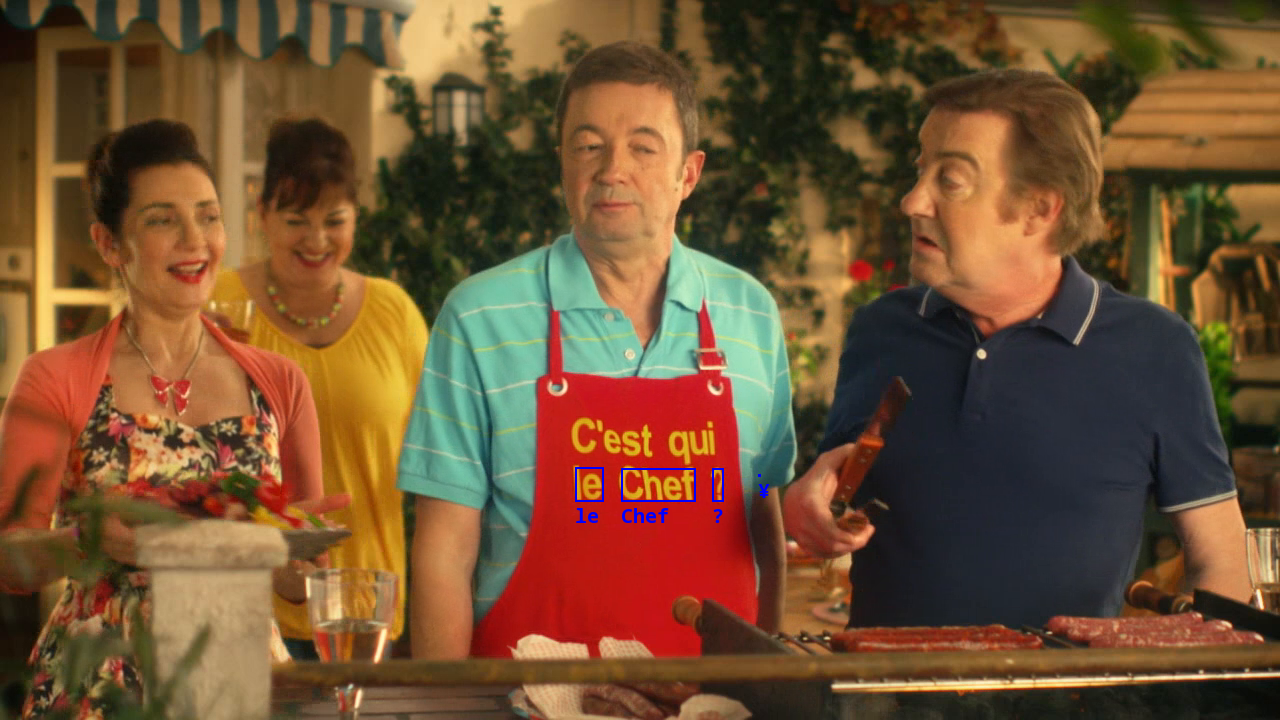

In [11]:
txt_frame, txts_to_draw = mult_txt_frames[102]

first_txt = get_frame_by_number(clip, txt_frame)

bb_frame = draw_text_bb(first_txt, txts_to_draw['text'])
display(bb_frame)

In [46]:
def make_frame(clip, txts):
    """ Get the frame in 'txts' and draw all the texts in 'txts' on top of the frame. 
    Also return the timestamp in the clip of the detected frame.
    """
    txt_frame_number = txts['dimension_idx']
    txt_timestamp = txt_frame_number / clip.fps
    frame = get_frame_by_number(clip, txt_frame_number)
    bb_frame = draw_text_bb(frame, txts['text'])

    return txt_timestamp, bb_frame

In [48]:
def get_txt_clips(clip, texts_detected, txt_frame_duration, timestamp_offset=0):
    """ Make a list of clips with all the text frames in 'texts_detected' inserted in 'clip'. 
    text frames are inserted with a duration of 'txt_frame_duration'.
    'timestamp_offset' is used to determine the starting time of the first (textless) subclip.
    """
    clips = []
    for txt in texts_detected:
        ts, bb_frame = make_frame(clip, txt)

        if (timestamp_offset != ts):
            clips.append(clip.subclip(timestamp_offset, ts))

        txt_frame_clip = ImageClip(np.asarray(bb_frame), duration=txt_frame_duration)
        clips.append(txt_frame_clip)
        timestamp_offset = ts + txt_frame_duration

    return clips, timestamp_offset

In [49]:
txts_per_round = 100

txt_frame_duration = frame_duration
prev_ts = 0

f = open('txt_detection.txt', 'w')

# Create video clips with 'faces_per_round' amount of detected faces per clip. 
for round in range(len(txts_detected) // txts_per_round + 1):
    clips = []
    start_txt_number = round * txts_per_round
    end_txt_number = start_txt_number + txts_per_round
    txt_batch = txts_detected[start_txt_number:end_txt_number]
    clips, prev_ts = get_txt_clips(clip, txt_batch, txt_frame_duration, prev_ts)

    concatenate_videoclips(clips).write_videofile('txt_detection_' + str(round) + '.mp4', codec='libx264', fps=fps, logger=None, audio=False)
    f.write('file txt_detection_' + str(round) + '.mp4\n')
f.close()

In [50]:
# remove any existing output.mp4 file
if os.path.exists('output.mp4'):
    os.remove('output.mp4')
if os.path.exists(v_name + '_txt_detection.mp4'):
    os.remove(v_name + '_txt_detection.mp4')

# Concatenate all the files in the txt_detection.txt file into one final clip
# and write to .mp4 file.
subprocess.call("ffmpeg -f concat -safe 0 -i txt_detection.txt -c copy output.mp4", shell=True)

# Add audio to the final clip.
subprocess.call("ffmpeg -i output.mp4 -i " + v_name + "_audio.mp3 -c:v copy -c:a aac -map 0:v:0 -map 1:a:0 -shortest " + v_name + "_txt_detection.mp4", shell=True)

# Delete all the subclips.
for round in range(len(txts_detected) // txts_per_round + 1):
    os.remove('txt_detection_' + str(round) + '.mp4')

# Delete the txt_detection.txt file.
os.remove('txt_detection.txt')

# Delete the audio file.
os.remove(v_name + '_audio.mp3')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab